This notebook tries to check if the recorded coordinates are well interpreted

In [1]:
import csv
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import imageProcessing as ip

In [9]:
# .csv data file created by the annotate.py script where coordinates for the Weber Length are stored
csv_file_path = "coords.csv"

# Open the CSV file and read its contents into a dictionary
# The stored data is: picture_name, x1, y1, x2, y2 
with open(csv_file_path, mode='r') as file:
    reader = csv.DictReader(file)  # Use DictReader to automatically map rows to dictionaries
    data = [row for row in reader]  # Convert each row into a dictionary and store in a list

In [4]:
# Add the image to the image_data dictionnary (seemed more convenient but might actually be stupid)
for image_data in data:
    name = image_data["Image Name"]
    img_path = os.path.join("without_background", name)
    img = Image.open(img_path) 
    img_array = np.array(img)
    image_data["Image"] = img_array

In [7]:
# Create a channel that has activated pixels around point1 point2

def create_channel(point1, point2, shape=(100, 200), radius=3):
    """
    Creates an image channel of the given shape where circles of a given radius
    around point1 and point2 are set to 255, and the rest are zeros.

    Args:
        point1 (tuple): Coordinates (x, y) for the first point.
        point2 (tuple): Coordinates (x, y) for the second point.
        shape (tuple): Shape of the output channel (height, width).
        radius (int): Radius of the circles to draw around the points.

    Returns:
        numpy.ndarray: A 2D array representing the channel.
    """
    # Create a blank channel
    channel = np.zeros(shape, dtype=np.uint8)

    # Helper function to draw a circle around a point
    def draw_circle(center, radius):
        cx, cy = center
        y, x = np.ogrid[:shape[0], :shape[1]]  # Create grid of coordinates
        distance = (x - cx)**2 + (y - cy)**2  # Compute squared distances from center
        mask = distance <= radius**2  # Define the circular mask
        channel[mask] = 255  # Apply mask to set values to 255

    # Draw circles around the provided points
    draw_circle(point1, radius)
    draw_circle(point2, radius)

    return channel


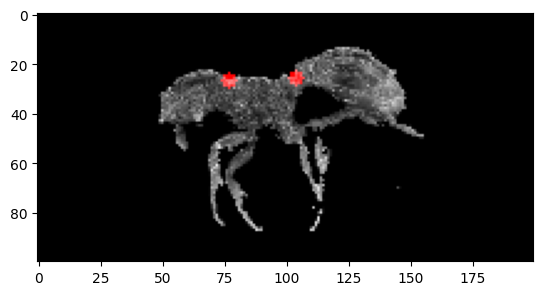

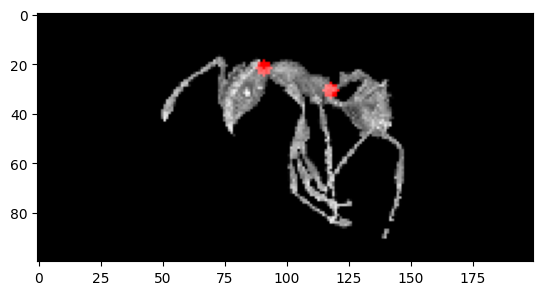

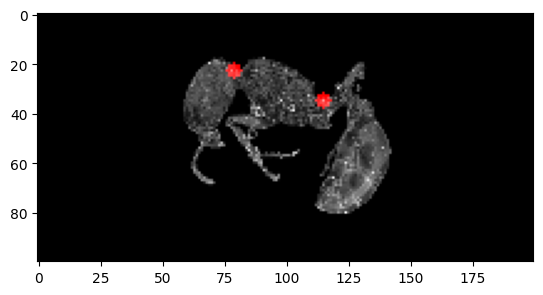

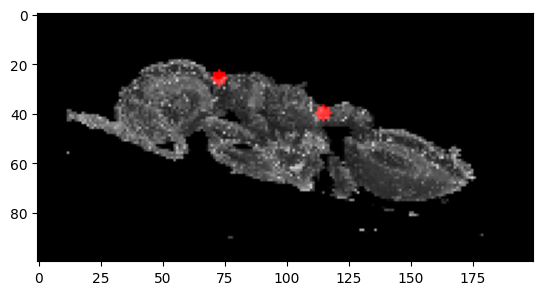

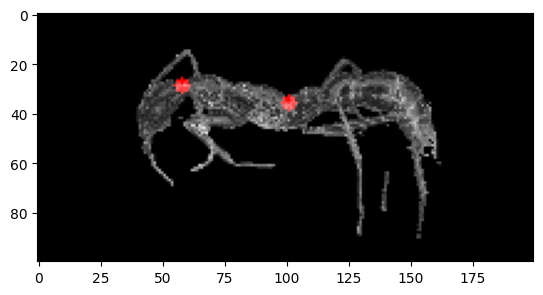

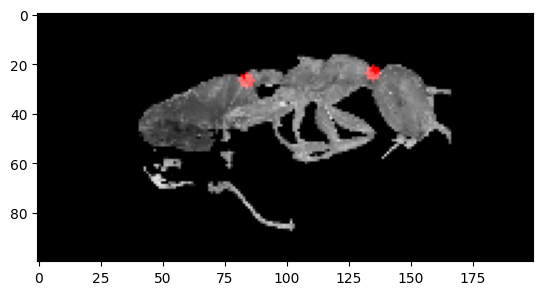

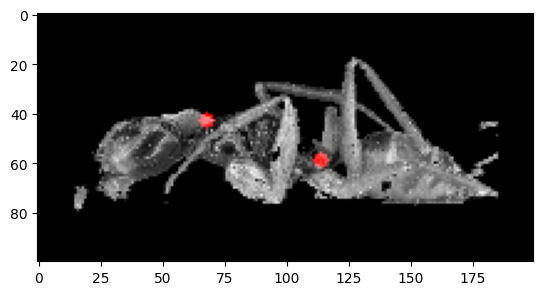

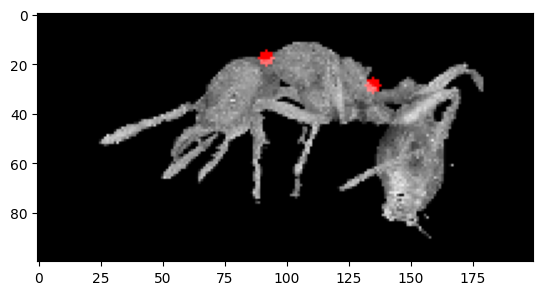

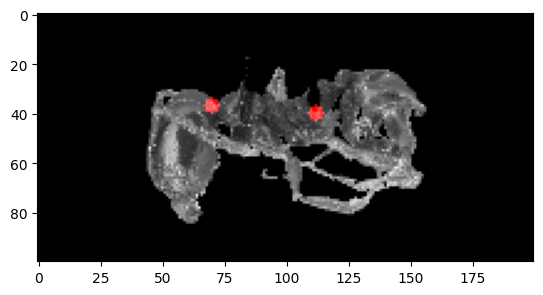

In [8]:
# Visualise if the points appear where we expect them to

for image_data in data:
    image = image_data["Image"]
    # simplified is a lighter version of the image. transform is the associated transformation that is applied to coordinates.
    # For example, after some padding, the point (x, y) gets shifted to (x + a, y + b), after downsampling it goes to (x/c, y/c)
    simplified, transform = ip.simplify_image(image)

    # Images that we didn't manage to pad because they were larger than target size (1000, 2000) are all zeros after simplify_image function
    if not (simplified == 0).all():
        # Get recorded points
        x1, y1 = image_data["x1"], image_data["y1"]
        x2, y2 = image_data["x2"], image_data["y2"]
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        
        # Update recorded points 
        transformed_point1, transformed_point2 = transform(x1, y1), transform(x2, y2)
        tx1, ty1, tx2, ty2 = transformed_point1[0], transformed_point1[1], transformed_point2[0], transformed_point2[1]

        # Create a channel to visualise the points
        point_channel = create_channel((tx1, ty1), (tx2, ty2))

        # Turn one-channel simplified image to 3 channels
        simplified_rgb = np.stack([simplified] * 3, axis=-1)
        
        # Integrate our channel that represents the points into the image
        red_channel = simplified_rgb[:, :, 0]
        red_channel = np.maximum(red_channel, point_channel)
        simplified_rgb[:, :, 0] = red_channel

        # Visualise the points
        plt.plot()
        plt.imshow(simplified_rgb)
        plt.show()

Success !!